In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import sys
import torch
from torchvision import transforms
sys.path.append('../src')
from datasets.synthetic_aes import SyntheticAES

/home/min/a/jgammell/miniconda3/envs/sca-defense/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = SyntheticAES(
    num_datapoints=100000,
    second_order_pairs=5,
    leakage_radius=5,
    hamming_weight_variance_prop=1.0
)
print(dataset)

SyntheticAES(
  num_datapoints               = 100000,
  timesteps_per_trace          = 500,
  first_order_points           = 0,
  second_order_pairs           = 5,
  fixed_profile_stdev          = 1.0,
  random_noise_stdev           = 1.0,
  hamming_weight_variance_prop = 1.0,
  desync_timesteps             = 0,
  leakage_radius               = 5,
  transform                    = None,
  target_transform             = None
)


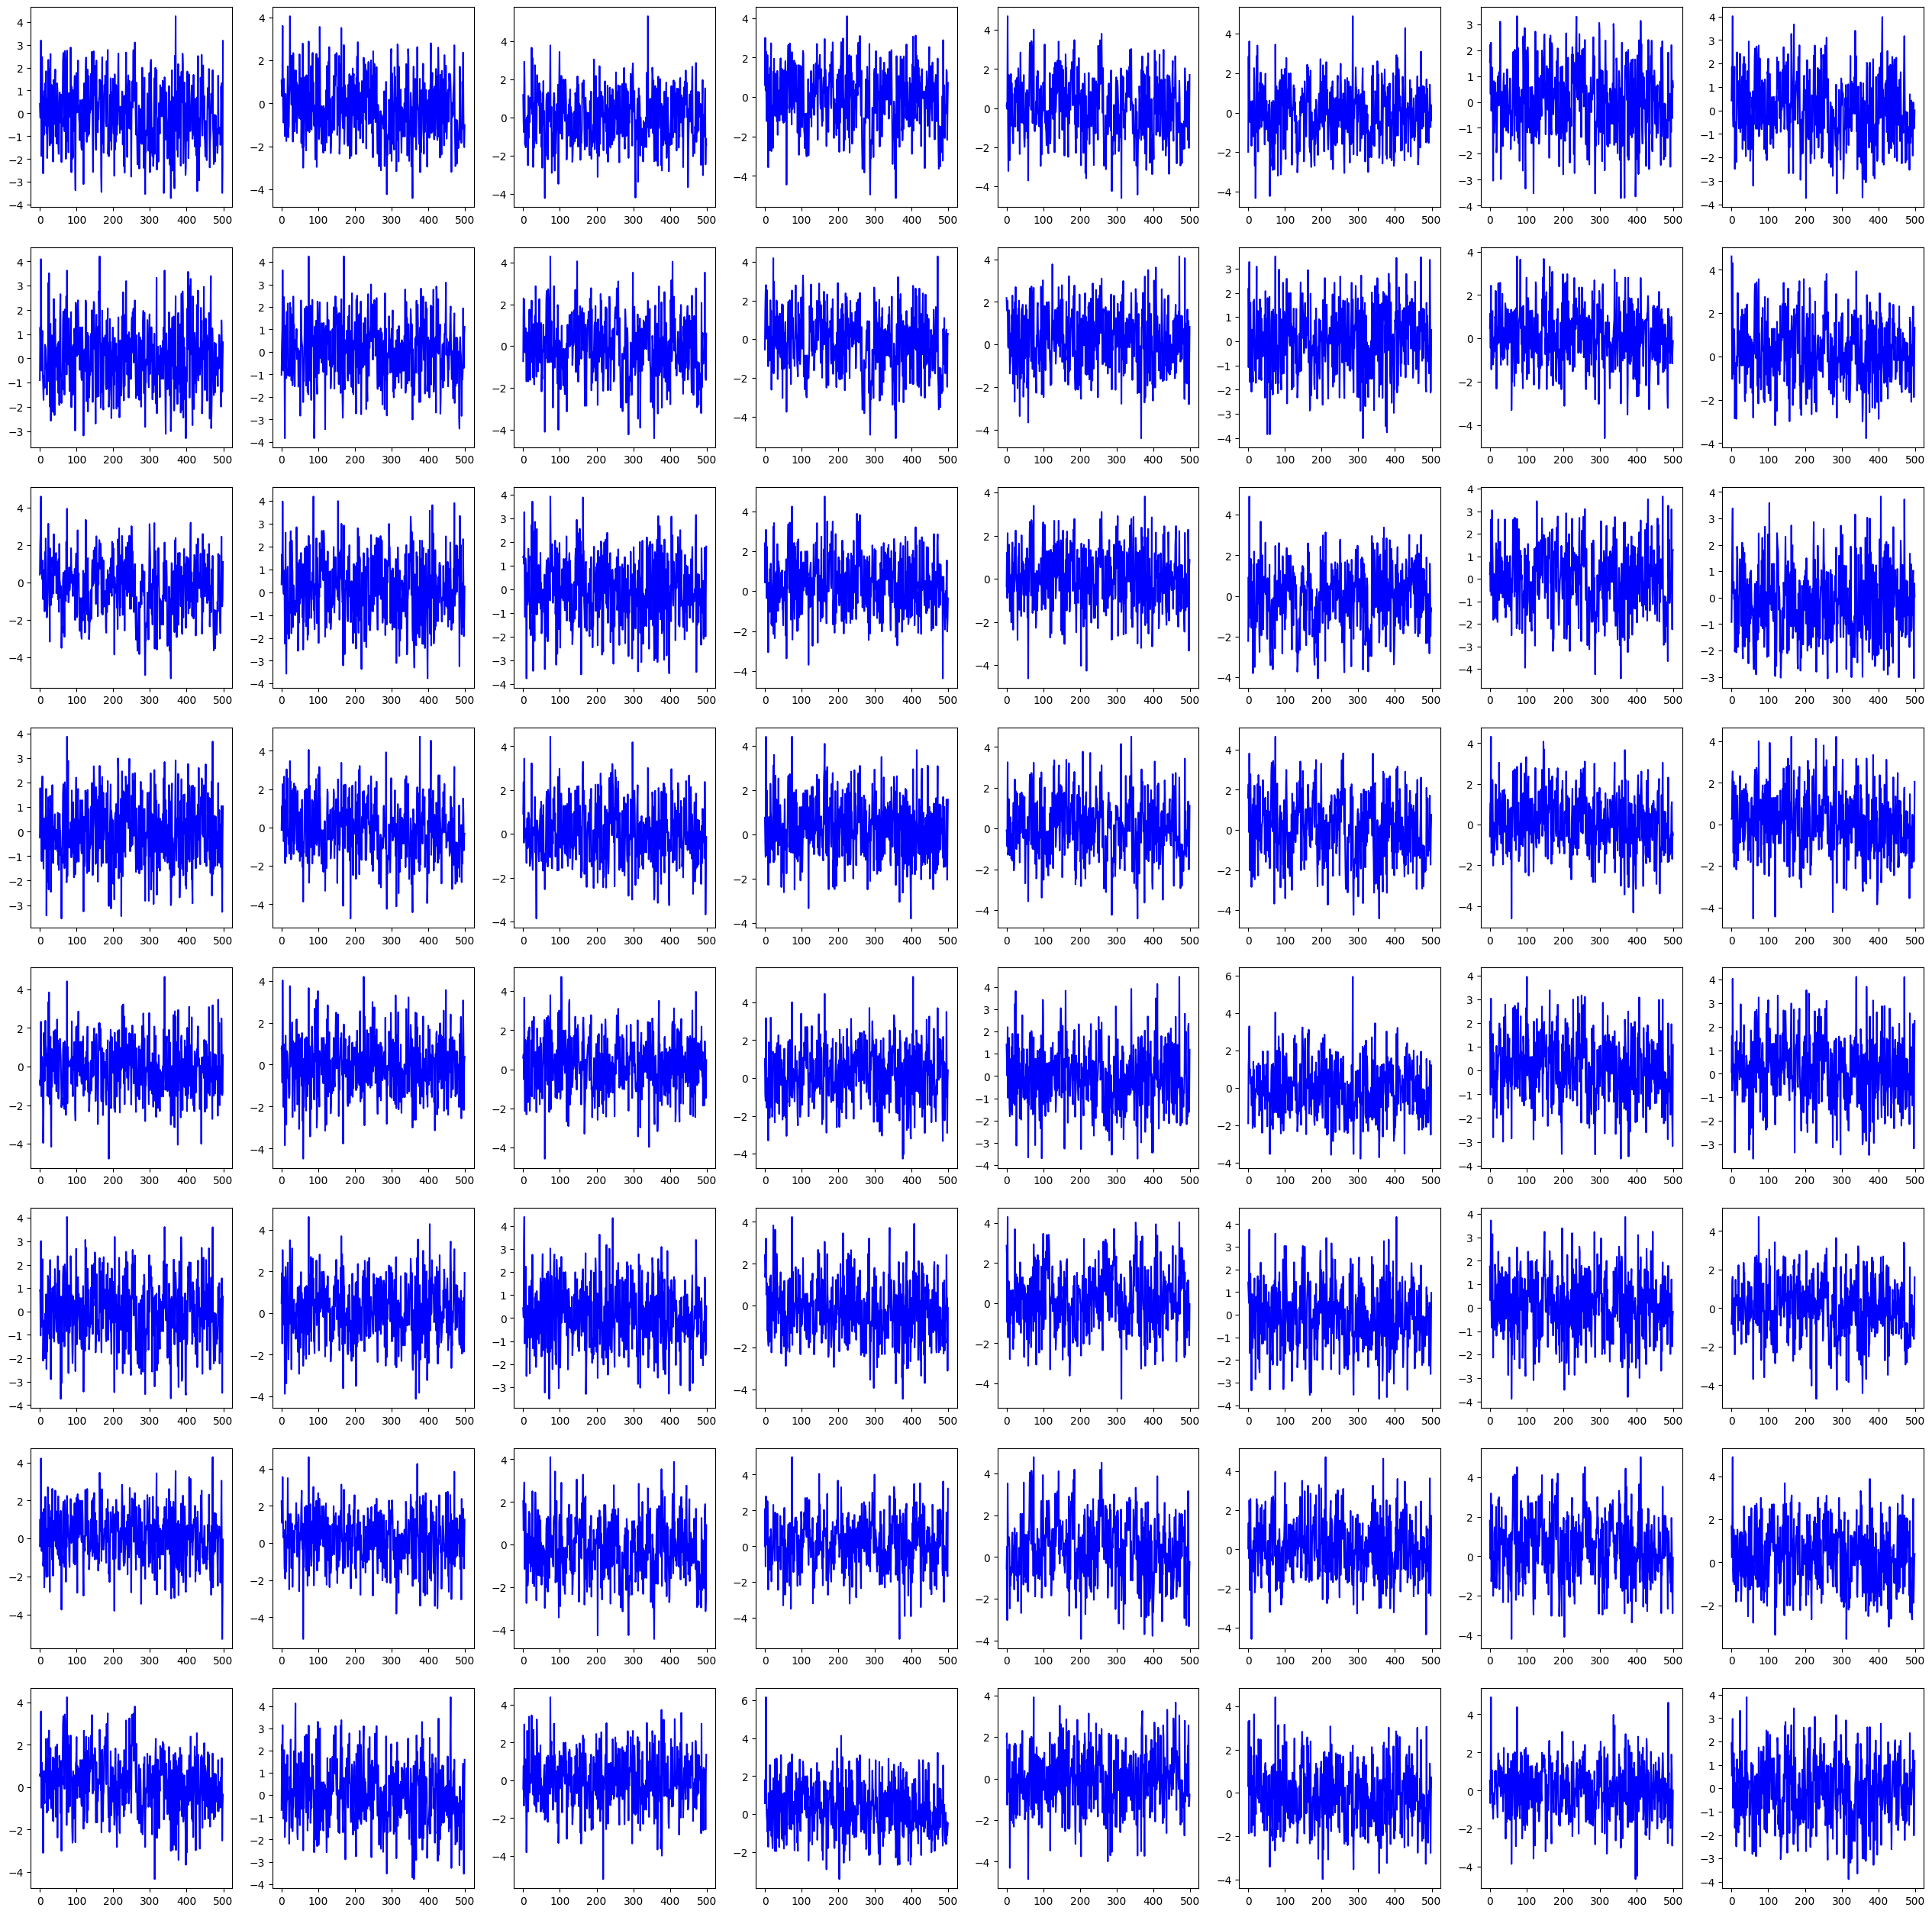

In [3]:
%matplotlib inline
traces_to_plot = 64
ax_scale = 4
rows = int(np.sqrt(traces_to_plot))
cols = int(np.ceil(traces_to_plot/rows))
fig, axes = plt.subplots(rows, cols, figsize=(cols*ax_scale, rows*ax_scale))
indices = np.random.choice(np.arange(len(dataset)), size=traces_to_plot, replace=False)
for idx, ax in zip(indices, axes.flatten()):
    trace, _ = dataset[idx]
    ax.plot(trace.squeeze(), color='blue')

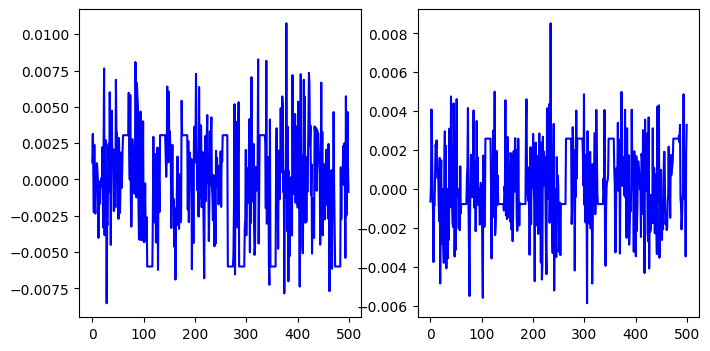

In [4]:
from datasets.utils import compute_mean_trace, compute_stdev_trace
mean_trace = compute_mean_trace(dataset)
stdev_trace = compute_stdev_trace(dataset, mean_trace=mean_trace)
fig, axes = plt.subplots(1, 2, figsize=(2*ax_scale, 1*ax_scale))
axes[0].plot((mean_trace - dataset.fixed_noise_profile).squeeze(), color='blue')
axes[1].plot(stdev_trace.squeeze() - 1, color='blue')

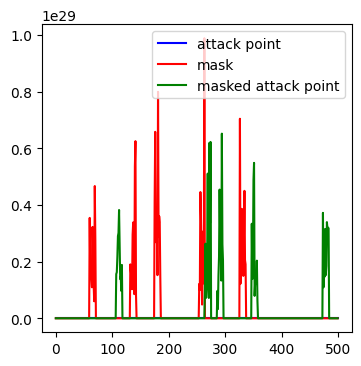

In [5]:
from datasets.utils import get_signal_to_noise_ratio
snr = get_signal_to_noise_ratio(dataset)
fig, ax = plt.subplots(1, 1, figsize=(ax_scale, ax_scale))
ax.plot(snr.squeeze(), color='blue', label='attack point')
if dataset.second_order_pairs > 0:
    mask_snr = get_signal_to_noise_ratio(dataset, metadata_target='mask')
    masked_ap_snr = get_signal_to_noise_ratio(dataset, metadata_target='masked_attack_point')
    ax.plot(mask_snr.squeeze(), color='red', label='mask')
    ax.plot(masked_ap_snr.squeeze(), color='green', label='masked attack point')
ax.legend()

SupervisedTrainer(
  classifier = MultilayerPerceptron(
    	input_shape:          (1, 500)
    	output_classes:       256
    	layer_sizes:          [512, 512]
    	activation(**kwargs): <class 'torch.nn.modules.activation.SELU'>({})
    (model): Sequential(
      (0): Linear(in_features=500, out_features=512, bias=True)
      (1): SELU()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): SELU()
    )
    (head): Linear(in_features=512, out_features=256, bias=True)
  ),
  classifier_optimizer = AdamW (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      capturable: False
      differentiable: False
      eps: 1e-08
      foreach: None
      fused: None
      lr: 0.0002
      maximize: False
      weight_decay: 0.01
  ),
  train_dataset = <torch.utils.data.dataset.Subset object at 0x7f8ac1c4b700>,
  train_dataloader = <torch.utils.data.dataloader.DataLoader object at 0x7f8bbcb7be20>,
  val_dataset = <torch.utils.data.dataset.Subset object at

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [11:36<00:00,  6.90s/it]


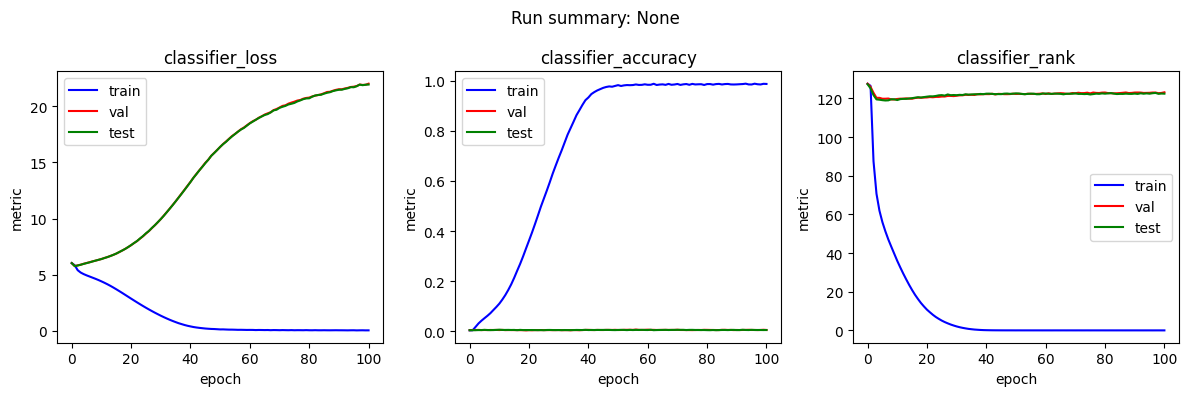

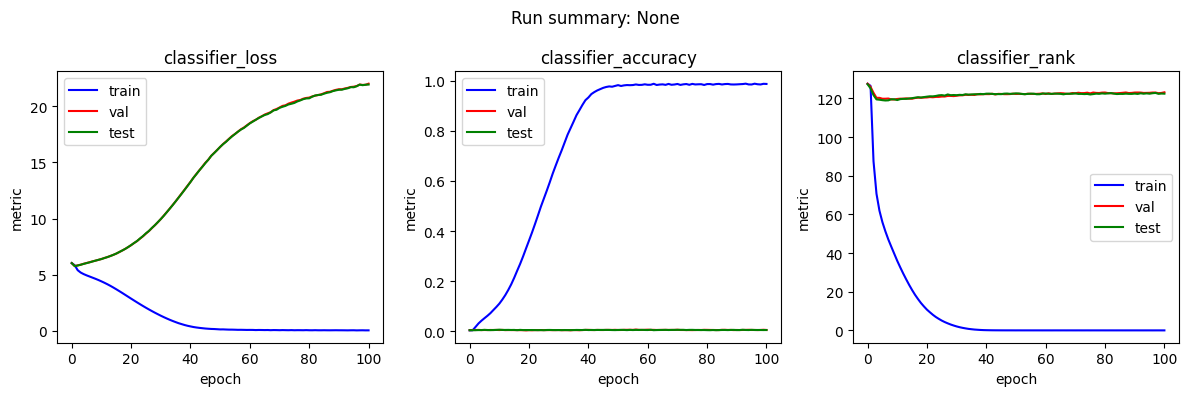

In [6]:
%matplotlib inline
from torch import nn, optim
from torch.utils.data import random_split
from torchvision import transforms
from leakage_detectors.supervised_trainer import SupervisedTrainer
from models.multilayer_perceptron import MultilayerPerceptron

data_transform = transforms.Compose([
    transforms.Lambda(lambda x: (x - mean_trace) / stdev_trace),
    transforms.Lambda(lambda x: torch.as_tensor(x, dtype=torch.float))
])
target_transform = transforms.Lambda(lambda x: torch.as_tensor(x, dtype=torch.long))
dataset.transform = data_transform
dataset.target_transform = target_transform
train_len = int(0.6*len(dataset))
val_len = int(0.2*len(dataset))
test_len = len(dataset) - train_len - val_len
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_len, val_len, test_len])

supervised_trainer = SupervisedTrainer(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    data_shape=dataset.trace_shape,
    output_classes=len(dataset.classes),
    dataloader_kwargs={'batch_size': 32, 'num_workers': 4, 'pin_memory': True},
    classifier_constructor=MultilayerPerceptron,
    classifier_kwargs={'layer_sizes': [512, 512]},
    classifier_optimizer_constructor=optim.AdamW,
    classifier_optimizer_kwargs={'lr': 2e-4},
    device=torch.device('cuda:0'),
    seed=0
)
print(supervised_trainer)
res = supervised_trainer.train(num_epochs=100)
supervised_trainer.plot_results(results=res, ret=True)